In [1]:
import os
import torch
from torch import nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.optim import Adam, SGD
from collections import defaultdict
import numpy.ma as ma
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# torch.backends.cudnn.enabled = False

cpu


In [2]:
# Define MNIST classifier MLP class for dataset
class MLP(nn.Module):
    def __init__(self, init_type='xavier', seed=None):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(196, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)
        
        if seed is not None:
            torch.manual_seed(seed)  # Set a unique seed for reproducibility

        self.init_weights(init_type)

    def init_weights(self, init_type):
        if init_type == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
        elif init_type == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        else:
            nn.init.normal_(self.fc1.weight)
            nn.init.normal_(self.fc2.weight)
            nn.init.normal_(self.fc3.weight)
        
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = x.view(-1, 196)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [3]:
# Set up data loader for MNIST
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


# Define the transform to downsample the images to 14x14 pixels
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((14, 14)),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset with the downsampling transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

train_data = datasets.MNIST('.', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

test_data = datasets.MNIST('.', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

Downsampled MNIST tensor shape: torch.Size([14, 14])


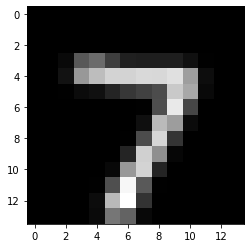

In [4]:
test_features, test_labels = next(iter(test_loader))
true = test_features[0].squeeze()
plt.imshow(true, cmap="gray")
print(f"Downsampled MNIST tensor shape: {true.shape}")



In [5]:
def train_mlp(model, epochs=3):
    criterion = nn.CrossEntropyLoss()
#     optimizer = Adam(model.parameters(), lr=0.001)
    optimizer = SGD(model.parameters(), lr=0.001) 
    # changed to SGD for speed. Models perform poorly - ~50% - on test loader vs ~90% from ADAM. 
    
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    

def test_mlp(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients for evaluation
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy
    
# Clerical functions
def save_model_weights(model, save_path):
    # Save actual weights and biases, not just their sizes
    weights = (
        (model.fc1.weight, model.fc2.weight, model.fc3.weight),
        (model.fc1.bias, model.fc2.bias, model.fc3.bias)
    )
    torch.save(weights, save_path)
    
def convert_to_tensor_format(point):
    """Convert tuple-based weights and biases to tensor-based format"""
    weights_tuple, biases_tuple = point[0], point[1]
    permutations = defaultdict(list)
    for i,(layer_weights,layer_biases) in enumerate(zip(weights_tuple,biases_tuple)): 
        permutations["layer_"+str(i+1)+"_weights"] = np.array(layer_weights.detach().cpu())
        permutations["layer_"+str(i+1)+"_biases"] = np.array(layer_biases.detach().cpu())
    return permutations

# Visualization stuffs
def load_and_flatten_weights(model_path):
    weights = torch.load(model_path)
    
    # Flatten the weight and bias sizes
    weight_flat = []
    for w in weights[0]:
        weight_flat.extend(w.view(-1).cpu().detach().numpy())
    
    bias_flat = []
    for b in weights[1]:
        bias_flat.extend(b.view(-1).cpu().detach().numpy())
    
    return np.array(weight_flat + bias_flat)

In [14]:
import time

def generate_and_save_clasifiers(N = 1, epochs = 1, start = 0):
    os.makedirs('models', exist_ok=True)
    for i in range(start, N):
        start = time.time()
        seed = i  # Unique seed for each model initialization
        init_type = 'xavier' if i % 2 == 0 else 'he'
        model = MLP(init_type=init_type, seed=seed)
        
        # Train the model for a few epochs 
        train_mlp(model, epochs=epochs) # reduced epochs to 1 for speed

        # Save the weights and biases as tuples of torch.Size
        save_path = f"models/reduced_mlp_weights_{i}.pt"
        save_model_weights(model, save_path)
        del model
        end = time.time()
        print(f"Saved model {i} weights to {save_path} in {(end-start):.3f}s")

#         accuracy = test_mlp(model, test_loader) # eliminate for speed
#         print(f"Model {i} Test Accuracy: {accuracy:.2f}%") 

generate_and_save_clasifiers(N = 1000, start = 710) # ended at 714 1/21 using SGD and 1 epoch

Saved model 95 weights to models/reduced_mlp_weights_95.pt in 19.030s
Saved model 96 weights to models/reduced_mlp_weights_96.pt in 22.962s
Saved model 97 weights to models/reduced_mlp_weights_97.pt in 22.894s
Saved model 98 weights to models/reduced_mlp_weights_98.pt in 22.858s
Saved model 99 weights to models/reduced_mlp_weights_99.pt in 22.909s
Saved model 100 weights to models/reduced_mlp_weights_100.pt in 19.288s
Saved model 101 weights to models/reduced_mlp_weights_101.pt in 19.204s
Saved model 102 weights to models/reduced_mlp_weights_102.pt in 19.208s
Saved model 103 weights to models/reduced_mlp_weights_103.pt in 19.203s
Saved model 104 weights to models/reduced_mlp_weights_104.pt in 19.195s
Saved model 105 weights to models/reduced_mlp_weights_105.pt in 19.215s
Saved model 106 weights to models/reduced_mlp_weights_106.pt in 19.193s
Saved model 107 weights to models/reduced_mlp_weights_107.pt in 19.213s
Saved model 108 weights to models/reduced_mlp_weights_108.pt in 19.228s
Sa

KeyboardInterrupt: 

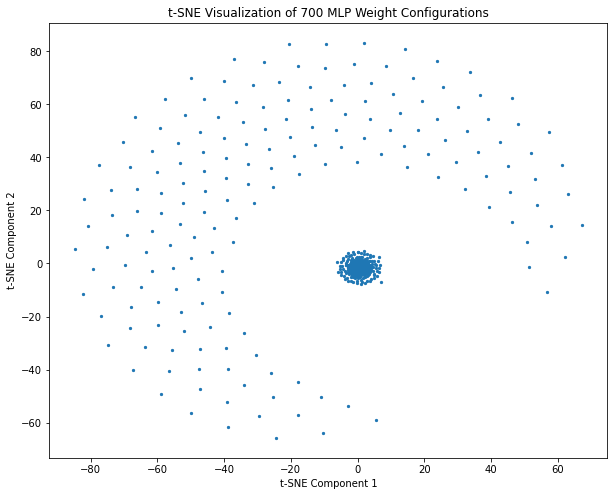

In [6]:
def plot_saved_weights(N = 10):
    weights_list = []
    for i in range(N):
        model_path = f"models/reduced_mlp_weights_{i}.pt"
        weights_list.append(load_and_flatten_weights(model_path))

    # Convert the list into a numpy array (shape: [1000, flattened_size])
    weights_matrix = np.array(weights_list)

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(weights_matrix)

    # Plot the t-SNE results
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], cmap='viridis', s=5)
    plt.title(f"t-SNE Visualization of {N} MLP Weight Configurations")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

plot_saved_weights(N = 700)

# Git Rebasin Infrastructure: 

In [7]:
# Functions for permutations and weight matching
def permute_layer_weights(layer, perm):
    """Permutes weights and biases of a layer based on the given permutation matrix."""
    weight = layer.weight.data.clone()
    bias = layer.bias.data.clone()

    # Permute rows of weights (output dimension)
    layer.weight.data = weight[perm, :]

    # Permute bias (output dimension)
    layer.bias.data = bias[perm]
    return layer

def permute_model(model, permutations):
    """Applies a list of permutations to a model's layers."""
    permute_layer_weights(model.fc1, permutations[0])
    permute_layer_weights(model.fc2, permutations[1])

    # Adjust input weights of the second hidden layer
    model.fc2.weight.data = model.fc2.weight.data[:, permutations[0]]
    # Adjust input weights of the output layer
    model.fc3.weight.data = model.fc3.weight.data[:, permutations[1]]
    return model

# Functions to permute weights and adjust input weights
def apply_permutation(layer, perm):
    """
    Applies the given permutation to the weights and biases of a layer.
    Args:
        layer: The layer to permute.
        perm: The permutation array.
    """
    # Permute rows (output dimension) of weights
    layer.weight.data = layer.weight.data[perm, :]
    # Permute biases
    layer.bias.data = layer.bias.data[perm]

def adjust_input_weights(layer, perm):
    """
    Adjusts the input wei
    ghts of a layer according to the permutation of the previous layer.
    Args:
        layer: The layer to adjust.
        perm: The permutation array of the previous layer.
    """
    layer.weight.data = layer.weight.data[:, perm]
    
def generate_permutation_matrix(hidden_dim):
    """Generates a random permutation matrix."""
    perm = np.random.permutation(hidden_dim)
    return torch.tensor(perm, dtype=torch.long)

def compute_similarity_matrix(weights_a, weights_b):
    """
    Computes the similarity matrix for two layers' weights.
    """
    weights_a = weights_a.view(weights_a.size(0), -1)
    weights_b = weights_b.view(weights_b.size(0), -1)
    return torch.matmul(weights_a, weights_b.T)

def get_permuted_weights(weights, perm):
    """
    Permutes the rows of weights based on the given permutation.
    """
    return weights[perm, :]


def weight_matching(rng, model_a, model_b, max_iter=100, init_perm=None):
    """
    Optimizes permutations to match Model B to Model A.
    """
    layers = ['fc1', 'fc2', 'fc3']
    perm_sizes = {layer: getattr(model_a, layer).weight.size(0) for layer in layers[:-1]}
    perm = {layer: np.arange(size) for layer, size in perm_sizes.items()} if init_perm is None else init_perm

    for iteration in range(max_iter):
        progress = False
        for layer in layers[:-1]:  # Exclude the output layer (fc3)
            n = perm_sizes[layer]
            similarity_matrix = compute_similarity_matrix(
                getattr(model_a, layer).weight.data,
                get_permuted_weights(getattr(model_b, layer).weight.data, perm[layer])
            )
            row_ind, col_ind = linear_sum_assignment(similarity_matrix.numpy(), maximize=True)

            old_score = np.sum(similarity_matrix.numpy()[np.arange(n), perm[layer]])
            new_score = np.sum(similarity_matrix.numpy()[np.arange(n), col_ind])

            if new_score > old_score:
                perm[layer] = col_ind
                progress = True

        if not progress:
            break

    return perm, new_score

def rebase_model_b_to_a(rng, model_a, model_b, max_iter=100):
    """
    Rebases Model B to match Model A using weight matching.
    """
    # Generate initial permutations
    init_perm = {layer: generate_permutation_matrix(getattr(model_a, layer).weight.size(0)) for layer in ['fc1', 'fc2']}
    
    # Perform weight matching
    permutations, score = weight_matching(rng, model_a, model_b, max_iter=max_iter, init_perm=init_perm)
    
    # Apply the permutations to Model B
    model_b = permute_model(model_b, [permutations['fc1'], permutations['fc2']])
    
    return model_b, permutations, score


In [8]:
def load_model_weights(model, weight_path):
    # Load weights and biases
    weights, biases = torch.load(weight_path)
    model.fc1.weight.data = weights[0]
    model.fc2.weight.data = weights[1]
    model.fc3.weight.data = weights[2]
    model.fc1.bias.data = biases[0]
    model.fc2.bias.data = biases[1]
    model.fc3.bias.data = biases[2]
    return model

def reconstruct_model(model, final_permutations):
    """
    Reconstruct model_b by applying the final permutations to its layers.
    Args:
        model_b (MLP): The model to be reconstructed.
        final_permutations (dict): Dictionary containing layer-wise permutations.
    Returns:
        MLP: The reconstructed model.
    """
    # Apply permutations to fc1 layer
    apply_permutation(model.fc1, final_permutations[1]['fc1'])
    adjust_input_weights(model.fc2, final_permutations[1]['fc1'])
    
    # Apply permutations to fc2 layer
    apply_permutation(model.fc2, final_permutations[1]['fc2'])
    adjust_input_weights(model.fc3, final_permutations[1]['fc2'])
    
    # Return the reconstructed model
    return model

In [9]:
model_path = f"models/reduced_mlp_weights_0.pt"
model_a = MLP()
model_a = load_model_weights(model_a, model_path)
print(test_mlp(model_a, test_loader))
    
model_path_b = f"models/reduced_mlp_weights_1.pt"
model_b = MLP()
model_b = load_model_weights(model_b, model_path_b)
print(test_mlp(model_b, test_loader))

rng = np.random.default_rng(42)
perm_model_b, final_permutations, score = rebase_model_b_to_a(rng, model_a, model_b, max_iter=100)
print(final_permutations, score)
print(test_mlp(perm_model_b, test_loader))


91.69
90.94
{'fc1': array([12,  8, 17, 26, 15, 11, 29,  9, 27, 22,  5,  0, 21, 30,  1,  6, 20,
       19,  7, 24,  4, 28, 18, 31,  2, 16, 14, 13, 25, 23, 10,  3]), 'fc2': array([30, 26, 19, 12,  7,  6, 29, 23,  3, 25, 28, 20,  0, 18, 21,  8, 24,
        4, 14,  1, 11, 15, 10, 17,  9, 13,  5, 31, 16,  2, 22, 27])} 18.127773
90.94


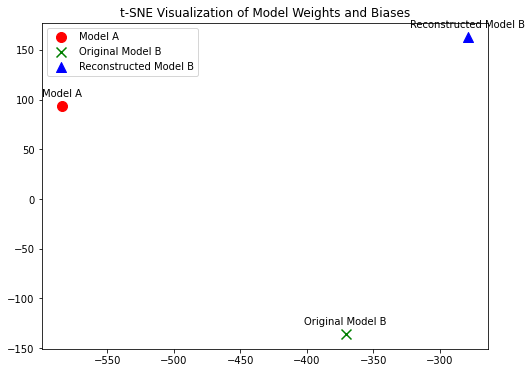

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import numpy as np

def extract_weights_and_biases(model):
    """Flatten the weights and biases of each layer in the model into a single vector."""
    all_weights_biases = []
    
    # Flatten weights and biases for each layer
    for layer_name in ['fc1', 'fc2', 'fc3']:
        weights = getattr(model, layer_name).weight.data.numpy().flatten()  # Flatten the weights
        biases = getattr(model, layer_name).bias.data.numpy().flatten()    # Flatten the biases
        all_weights_biases.extend(weights)
        all_weights_biases.extend(biases)
    
    return np.array(all_weights_biases)

def plot_tsne(model_a, model_b, reconstructed_model_b, perplexity=5):
    """Plot t-SNE of weights and biases for model_a, model_b, and reconstructed_model_b."""
    # Extract weights and biases for each model
    model_a_data = extract_weights_and_biases(model_a)
    model_b_data = extract_weights_and_biases(model_b)
    reconstructed_model_b_data = extract_weights_and_biases(reconstructed_model_b)
    
    # Combine the data for t-SNE (3 sets of weights + biases)
    all_data = np.vstack([model_a_data, model_b_data, reconstructed_model_b_data])
    
    # Apply t-SNE to reduce dimensionality
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    tsne_results = tsne.fit_transform(all_data)
    
    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_results[0, 0], tsne_results[0, 1], color='r', label='Model A', s=100, marker='o')
    plt.scatter(tsne_results[1, 0], tsne_results[1, 1], color='g', label='Original Model B', s=100, marker='x')
    plt.scatter(tsne_results[2, 0], tsne_results[2, 1], color='b', label='Reconstructed Model B', s=100, marker='^')
    
    # Annotate the points
    plt.annotate('Model A', (tsne_results[0, 0], tsne_results[0, 1]), textcoords="offset points", xytext=(0, 10), ha='center')
    plt.annotate('Original Model B', (tsne_results[1, 0], tsne_results[1, 1]), textcoords="offset points", xytext=(0, 10), ha='center')
    plt.annotate('Reconstructed Model B', (tsne_results[2, 0], tsne_results[2, 1]), textcoords="offset points", xytext=(0, 10), ha='center')
    
    # Set labels and title
    plt.title("t-SNE Visualization of Model Weights and Biases")
    plt.legend(loc='best')
    plt.show()

# Assuming you have model_a, model_b, and reconstructed_model_b loaded
plot_tsne(model_a, model_b, perm_model_b, perplexity=2)

# Apply Rebasin:

In [11]:
import time

def get_permuted_models_data(ref_point=0, N = 10):
    ref_model = MLP()
    ref_model_path = f"models/reduced_mlp_weights_{ref_point}.pt"
    ref_model = load_model_weights(ref_model, ref_model_path)
    
    org_models=[]
    permuted_models = []
    full_times = []
    rebasin_times = []
    scores = []
    rng = np.random.default_rng(42)

    for i in range(0,N):
        if i == ref_point:
            continue
        all_start = time.time() # start timing
        model_path = f"models/reduced_mlp_weights_{i}.pt"
        model = MLP()
        model = load_model_weights(model, model_path)
        org_models.append(model)
        loaded_model = time.time() # end timing for loading the model from .pth file
        
        reconstructed_model, final_permutations, score = rebase_model_b_to_a(rng, ref_model, model, max_iter=100)
        scores.append(score)
        permuted_models.append(reconstructed_model)
        all_end = time.time() # end timing for the entire loop
        
        full_times.append(all_end - all_start)
        rebasin_times.append(all_end - loaded_model)
        
#         print(f"Org model accuracy:{test_mlp(model, test_loader)} Reconstructed model accuracy:{test_mlp(reconstructed_model, test_loader)}")
    return org_models, permuted_models, scores, rebasin_times

In [12]:
org_models, permuted_models, scores, rebasin_times = get_permuted_models_data(ref_point=0, N = 710)

In [13]:
# del org_models, permuted_models, scores, rebasin_times

In [14]:
from typing import Tuple, NamedTuple
from torch.utils.data import Dataset, DataLoader

class Batch(NamedTuple):
    weights: Tuple
    biases: Tuple

    def _assert_same_len(self):
        assert len(set([len(t) for t in self])) == 1

    def as_dict(self):
        return self._asdict()

    def to(self, device):
        """move batch to device"""
        return self.__class__(
            weights=tuple(w.to(device) for w in self.weights),
            biases=tuple(w.to(device) for w in self.biases),        )

    def __len__(self):
        return len(self.weights[0])
    

# Custom Dataset to extract weights and biases
class MLPParameterDataset(Dataset):
    def __init__(self, mlp_list: list):
        """
        Initialize the dataset with a list of MLP objects.
        Args:
            mlp_list (list): List of MLP objects
        """
        self.mlp_list = mlp_list

    def __len__(self) -> int:
        """
        Return the number of MLP objects in the dataset.
        """
        return len(self.mlp_list)

    def __getitem__(self, idx: int) -> Tuple[Tuple[torch.Tensor], Tuple[torch.Tensor]]:
        """
        Extract the weights and biases of the MLP at index `idx`.
        Args:
            idx (int): Index of the MLP object
        Returns:
            Batch( Tuple[Tuple[torch.Tensor], Tuple[torch.Tensor]] ):
                - A tuple containing:
                    - Tuple of weights (torch.Tensor for each layer)
                    - Tuple of biases (torch.Tensor for each layer)
        """
        mlp = self.mlp_list[idx]

        # Extract weights and biases from each layer
        # Permute/unsqueeze tensors to have bs, input dim, output dim, 1
        weights = tuple(layer.weight.data.clone().permute(1, 0).unsqueeze(-1) for layer in [mlp.fc1, mlp.fc2, mlp.fc3])
        biases = tuple(layer.bias.data.clone().unsqueeze(-1) for layer in [mlp.fc1, mlp.fc2, mlp.fc3])

        return Batch(weights, biases)

def sample_first_mlp_from_batch(batch: Batch, init_type: str = 'xavier', seed: int = None) -> MLP:
    """
    Sample the first MLP from a batch and reconstruct it as an MLP object.

    Args:
        batch (Batch): A Batch instance containing weights and biases for a batch of MLPs.
        init_type (str): Initialization type for the MLP (default: 'xavier').
        seed (int): Seed for reproducibility (default: None).

    Returns:
        MLP: Reconstructed MLP object with weights and biases from the first sample in the batch.
    """
    # Create a new MLP instance
    mlp = MLP(init_type=init_type, seed=seed)

    # Ensure the batch has the same number of layers as the MLP
#     assert len(batch.weights) == len(batch.biases) == 3, "Batch must have 3 layers."

    # Extract the first sample's weights and biases
    first_weights = tuple(w[0].squeeze(-1) for w in batch[0])  # Index first and remove last dim
    first_biases = tuple(b[0].squeeze(-1) for b in batch[1])    # Index first and remove last dim

    # Assign weights and biases to the new MLP instance
    with torch.no_grad():
        for layer, w, b in zip([mlp.fc1, mlp.fc2, mlp.fc3], first_weights, first_biases):
            layer.weight.data = w.permute(1, 0).clone()  # Transpose back to [output_dim, input_dim]
            layer.bias.data = b.clone()

    return mlp


In [15]:
# Create a dataset and dataloader
dataset = MLPParameterDataset(permuted_models)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
del org_models, permuted_models, scores, rebasin_times

# DWS AutoEncoder:

In [16]:
from nn.models import DWSModel
from typing import Tuple, NamedTuple
from nn.layers import BN, DWSLayer,InvariantLayer, Dropout, ReLU
from nn.layers.base import BaseLayer,GeneralSetLayer

In [54]:
class DWSEncoder(BaseLayer):
    def __init__(
       self,
        weight_shapes,
        bias_shapes,
        input_features,
        hidden_dims,
        downsample_dim,
        n_hidden=2,
        reduction="max",
        bias=True,
        n_fc_layers=1,
        num_heads=4,
        set_layer="sab",
        add_layer_skip=False,
        input_dim_downsample=None,
        init_scale=1.,
        init_off_diag_scale_penalty=1.,
        bn=False,
        dropout_rate = 0.001,
        diagonal=False,
    ):
        super().__init__(
            in_features=input_features,
            out_features=hidden_dims,
            bias=bias,
            reduction=reduction,
            n_fc_layers=n_fc_layers,
            num_heads=num_heads,
            set_layer=set_layer,
        )

        self.downsample_dim = downsample_dim
        self.bias = bias
        self.n_fc_layers = n_fc_layers
        self.num_heads = num_heads
        
#         self.skip = self._get_mlp(
#             in_features=input_features,
#             out_features=input_features,
#             bias=bias,
#         )
        
        self.InitialLayer = DWSModel(
            weight_shapes=weight_shapes,
            bias_shapes=bias_shapes,
            input_features=input_features,
            hidden_dim=hidden_dims,
            n_hidden=n_hidden,
            reduction=reduction,
            bias=bias,
            output_features=input_features,
            n_fc_layers=n_fc_layers,
            num_heads=num_heads,
            set_layer=set_layer,
            dropout_rate=dropout_rate,
            input_dim_downsample=input_dim_downsample,
            init_scale=init_scale,
            init_off_diag_scale_penalty=init_off_diag_scale_penalty,
            bn=bn,
            add_skip=False,
            add_layer_skip=add_layer_skip,
            diagonal=diagonal,
        )   

    def downsample_input_weights(self, inputs, downsample_dim):
        """Downsample the input weights to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first weight dimension [32,2,32,1] -> [32,2,8,1]
        inputs[0] = self._downsample_weight(inputs[0], dim=2, downsample_dim = downsample_dim)
        # Downsample second weight dimension [32,32,32,1] -> [32,8,8,1]
        inputs[1] = self._downsample_weight(inputs[1], dim=1, downsample_dim = downsample_dim)
        inputs[1] = self._downsample_weight(inputs[1], dim=2, downsample_dim = downsample_dim)

        # Downsample third weight dimension [32,32,1,1] -> [32,8,1,1]
        inputs[2] = self._downsample_weight(inputs[2], dim=1, downsample_dim = downsample_dim)

        return tuple(inputs)

    def downsample_input_biases(self, inputs, downsample_dim):
        """Downsample the input biases to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first bias dimension [32,32,1] -> [32,8,1]
        inputs[0] = self._downsample_bias(inputs[0], downsample_dim= downsample_dim)

        # Downsample second bias dimension [32,32,1] -> [32,8,1]
        inputs[1] = self._downsample_bias(inputs[1], downsample_dim = downsample_dim)

        return tuple(inputs)
    
    def batchNormLayer(self,weights, biases):
        relu = nn.ReLU()
        weights = tuple(relu(nn.BatchNorm2d(w.shape[1]).to(device)(w)) for w in weights)
        biases = tuple(relu(nn.BatchNorm1d(b.shape[1]).to(device)(b.squeeze(-1)).unsqueeze(-1)) for b in biases)
        return weights, biases

    def forward(self, x: Tuple[Tuple[torch.tensor], Tuple[torch.tensor]]):
        """Forward pass through the encoder."""
        x = self.InitialLayer(x)
        weights = self.downsample_input_weights(x[0], 2 * self.downsample_dim)
        biases = self.downsample_input_biases(x[1], 2 * self.downsample_dim)
#         weights, biases = self.batchNormLayer( weights, biases) ###### BREAKS EVERYTHING #######
        weights = self.downsample_input_weights(weights, self.downsample_dim)
        biases = self.downsample_input_biases(biases, self.downsample_dim)
        out = (weights, biases)
        return out

    def _downsample_weight(self, weight, dim,downsample_dim):
        d0 = weight.shape[dim]
        down_sample = GeneralSetLayer(
            in_features=d0,
            out_features= downsample_dim,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        wi = weight.permute(0, 3, 1, 2) if dim == 2 else weight.permute(0, 3, 2, 1)
        wi = down_sample(wi)
        return wi.permute(0, 2, 3, 1) if dim == 2 else wi.permute(0, 3, 2, 1)

    def _downsample_bias(self, bias, downsample_dim):
        d0 = bias.shape[1]
        down_sample = GeneralSetLayer(
            in_features=d0,
            out_features=downsample_dim,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        wi = bias.permute(0, 2, 1)
        wi = down_sample(wi)
        return wi.permute(0, 2, 1)

In [88]:
# I think the decoder is slow/bad? 
class Decoder(nn.Module,
             ):
    def __init__(self, upsample_dim,
                weight_shapes,
                bias_shapes,
                input_features,
                hidden_dims,
                downsample_dim,
                n_hidden=2,
                reduction="max",
                set_layer="sab",
                add_layer_skip=False,
                input_dim_downsample=None,
                init_scale=1.,
                init_off_diag_scale_penalty=1.,
                bn=False,
                dropout_rate = 0.001,
                diagonal=False,
                bias=True,
                n_fc_layers=1,
                num_heads=4):
        
        super(Decoder, self).__init__()
        
        self.upsample_dim = upsample_dim
        self.bias = bias
        self.n_fc_layers = n_fc_layers
        self.num_heads = num_heads
        
        self.InitialLayer = DWSModel(
            weight_shapes= weight_shapes,
            bias_shapes= bias_shapes,
            input_features=input_features,
            hidden_dim=hidden_dims,
            n_hidden=n_hidden,
            reduction=reduction,
            bias=bias,
            output_features=input_features,
            n_fc_layers=n_fc_layers,
            num_heads=num_heads,
            set_layer=set_layer,
            dropout_rate=dropout_rate,
            input_dim_downsample=input_dim_downsample,
            init_scale=init_scale,
            init_off_diag_scale_penalty=init_off_diag_scale_penalty,
            bn=bn,
            add_skip=False,
            add_layer_skip=add_layer_skip,
            diagonal=diagonal,
        )   
        
    def upsample_input_weights(self, inputs, upsample_to):
        """Upsample the input weights to the specified dimensions."""
        inputs = list(inputs)
        
#         print(len(inputs))
#         print(f"2nd weights pre-op: {inputs[1].shape}")

        # Downsample first weight dimension [32,2,8,1] -> [32,2,32,1]
        inputs[0] = self._upsample_weight(inputs[0], upsample_to, dim=2 , index = 0)

        # Downsample second weight dimension [32,8,8,1] -> [32,32,32,1]
        inputs[1] = self._upsample_weight(inputs[1], upsample_to, dim=1, index = 1)
#         print(f" 2nd weights dim 1: {inputs[1].shape}")
        
        inputs[1] = self._upsample_weight(inputs[1], upsample_to, dim=2, index = 1)
#         print(f" 2nd weights dim 2: {inputs[1].shape}")

    
        # Downsample third weight dimension [32,8,1,1] -> [32,32,1,1]
        inputs[2] = self._upsample_weight(inputs[2], upsample_to, dim=1, index = 2)

        return tuple(inputs)

    def upsample_input_biases(self, inputs, upsample_to):
        """Upsample the input biases to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first bias dimension [32,8,1] -> [32,32,1]
        inputs[0] = self._upsample_bias(inputs[0], upsample_to, index = 0)

        # Downsample second bias dimension [32,8,1] -> [32,32,1]
        inputs[1] = self._upsample_bias(inputs[1], upsample_to, index = 1)

        return tuple(inputs)
    
    def _upsample_weight(self, weight, upsample_to, dim, index):
        d0 = weight.shape[dim]
        up_sample = GeneralSetLayer(
            in_features=d0,
            out_features=upsample_to,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        wi = weight.permute(0, 3, 1, 2) if dim == 2 else weight.permute(0, 3, 2, 1)
        wi = up_sample(wi)
        wi = wi.permute(0, 2, 3, 1) if dim == 2 else wi.permute(0, 3, 2, 1)
        return wi 

    def _upsample_bias(self, bias, upsample_to, index):
        d0 = bias.shape[1]
        up_sample = GeneralSetLayer(
            in_features=d0,
            out_features=upsample_to,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        bi = bias.permute(0, 2, 1)
        bi = up_sample(bi)
        bi = bi.permute(0, 2, 1)
        return bi


    def forward(self, x):
        # Decode weight tensors
        weight_space = self.upsample_input_weights(x[0], int(1/2 * self.upsample_dim) )
        bias_space = self.upsample_input_biases(x[1], int(1/2 * self.upsample_dim) )
        
        weight_space = self.upsample_input_weights(weight_space, self.upsample_dim)
        bias_space = self.upsample_input_biases(bias_space, self.upsample_dim)
        
        output = self.InitialLayer((weight_space , bias_space))
        return output

In [113]:
# Our AutoEncoder using DWSModel
class AutoEncoder(nn.Module):
    def __init__(self,
            input_features,
            weight_shapes,
            bias_shapes,
            hidden_dims,
            downsample_dim,
            n_hidden=1,
            n_fc_layers=1,
            reduction = "max",
            input_dim_downsample=None,
            bn = False,
    ):
        super().__init__()
        self.encoder = DWSEncoder(weight_shapes=weight_shapes,
                                bias_shapes=bias_shapes,
                                input_features=input_features,
                                hidden_dims=hidden_dims,
                                downsample_dim = downsample_dim,
                                n_hidden=n_hidden,
                                n_fc_layers = n_fc_layers,
                                reduction=reduction,
                                input_dim_downsample=input_dim_downsample,
                                bn=bn).to(device)
        self.decoder = Decoder(upsample_dim = 32, # ew hardcoded dims
                               weight_shapes=weight_shapes,
                               bias_shapes=bias_shapes,
                               input_features = input_features,
                               hidden_dims = hidden_dims,
                               n_hidden=n_hidden,
                               n_fc_layers = n_fc_layers,
                               downsample_dim = downsample_dim,
                               input_dim_downsample = input_dim_downsample,
                               ).to(device)
        
    def forward(self,inputs):
        encoded_data = self.encoder(inputs)
        output = self.decoder(encoded_data)
        return encoded_data, output

In [79]:
# To-Do:
# Implement rebasin score in loss 
class TupleLoss(nn.Module):
    def __init__(self):
        super(TupleLoss, self).__init__()
        self.mse_loss = torch.nn.MSELoss()

    def forward(self, output, target):
        weights1, biases1 = output
        weights2, biases2 = target

        # Compute MSE for weights
        weight_loss = sum(
            self.mse_loss(w1.flatten(), w2.flatten()) for w1, w2 in zip(weights1, weights2)
        ) / len(weights1)

        # Compute MSE for biases
        bias_loss = sum(
            self.mse_loss(b1.flatten(), b2.flatten()) for b1, b2 in zip(biases1, biases2)
        ) / len(biases1)

        # Combine the losses
        total_loss = 0.5 * weight_loss + 0.5 * bias_loss

        return total_loss

    
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss = 0.0
    total = 0.0
    criterion = TupleLoss()
    for batch in loader:
        batch = batch.to(device)
        inputs = (batch.weights, batch.biases)
        _ ,out = model(inputs)
        loss += criterion(out, inputs)
        total += 1

    model.train()
    avg_loss = loss / total

    return avg_loss


import logging
import torch
from tqdm import trange
from torch.cuda.amp import GradScaler, autocast

def train_model(model, train_loader, num_epochs = 1, accumulation_steps = 2):
    learning_rate = 1e-3
    criterion = TupleLoss()
    epoch_iter = trange(num_epochs)
    epoch_loss = -1
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=5)
    previous_epoch_loss = 1000

    for epoch in epoch_iter:
        start = time.time()
        total_loss = 0
        counter = 0
        
        optimizer.zero_grad()  # Initialize optimizer's gradients at the start of each epoch
        
        for i, batch in enumerate(train_loader):
            model.train() 
            
            batch = batch.to(device)
            inputs = (batch.weights, batch.biases)
            
            _, out = model(inputs)

            loss = criterion(out, inputs)/accumulation_steps

            del out, inputs, batch
            torch.cuda.empty_cache()  # Clear memory
            
            loss.backward() 
            
            total_loss += loss.item() * accumulation_steps  # Scale back accumulated loss
            counter += 1
            
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()                        
                epoch_loss = total_loss / counter
                total_loss = 0
                counter = 0
            
        losses.append(epoch_loss)
        scheduler.step(epoch_loss)
        end = time.time()
        epoch_iter.set_description(
            f"[{epoch} {i+1}], train loss: {loss.item():.5f}, epoch loss: {epoch_loss:.5f}, epoch time: {((end-start)/accumulation_steps):.3f}"
        )
        if epoch % 5 == 0:
            batch = next(iter(train_loader))
            model.eval() 
            
            batch = batch.to(device)
            inputs = (batch.weights, batch.biases)
            _, out = model(inputs)
            
            sampled_mlp = sample_first_mlp_from_batch(out)
            recon_test_acc = test_mlp(sampled_mlp, test_loader)
            print(f"Epoch {epoch + 1} sample reconstruction accuracy: {recon_test_acc}")

#         if epoch_loss < previous_epoch_loss:
#             model_path = f"Outputs/model_MLP_REBASIN.pth"
#             torch.save(model.state_dict(), model_path)
#             previous_epoch_loss = epoch_loss
            
#         if (epoch + 1) % 25 == 0:
#              print(evaluate(model, test_loader))

    print("Training complete!")
    steps_holder = np.linspace(0, len(losses), len(losses)) # this plot doesn't make sense. 
    plt.plot(steps_holder, losses)
    plt.title(f"Epoch Losses of Time")
    plt.xlabel(f"Epoch Number")
    plt.ylabel(f"Epoch Loss")


# Autoencoder setup:

In [80]:
rebasined_data = dataset.__getitem__(0)
weight_shapes = tuple(w.shape[:2] for w in rebasined_data[0])
bias_shapes = tuple(b.shape[:1] for b in rebasined_data[1])
print(weight_shapes, bias_shapes)

(torch.Size([196, 32]), torch.Size([32, 32]), torch.Size([32, 10])) (torch.Size([32]), torch.Size([32]), torch.Size([10]))


In [105]:
test_encoder = DWSEncoder(
                        weight_shapes=weight_shapes,
                        bias_shapes=bias_shapes,
                        input_features=1,
                        hidden_dims=8,
                        downsample_dim = 4,
                        n_hidden=1,
                        reduction= "max",
                        bn=True,
                        input_dim_downsample = 49
                        ).to(device)

a = next(iter(dataloader))
a = test_encoder(a)
weights, biases = a #next(iter(dataloader))
for i in range(len(weights)):
    print(f"Encoded Weight Shapes: {weights[i].shape}")
    
for j in range(len(biases)):
    print(f"Encoded Bias Shapes: {biases[i].shape}")
    

Encoded Weight Shapes: torch.Size([1, 196, 4, 1])
Encoded Weight Shapes: torch.Size([1, 4, 4, 1])
Encoded Weight Shapes: torch.Size([1, 4, 10, 1])
Encoded Bias Shapes: torch.Size([1, 10, 1])
Encoded Bias Shapes: torch.Size([1, 10, 1])
Encoded Bias Shapes: torch.Size([1, 10, 1])


In [106]:
test_decoder = Decoder(upsample_dim = 32, # ew hardcoded dims
                       weight_shapes=weight_shapes,
                       bias_shapes=bias_shapes,
                       input_features = 1,
                       hidden_dims = 8,
                       n_hidden=1,
                       reduction = "max",
                       n_fc_layers = 1,
                       downsample_dim = 4,
                       input_dim_downsample = 49,
                       ).to(device)
b = test_decoder(a)
weights, biases = b #next(iter(dataloader))
for i in range(len(weights)):
    print(f"Decoded Weight Shapes: {weights[i].shape}")
    
for j in range(len(biases)):
    print(f"Decoded Bias Shapes: {biases[i].shape}")
  

Decoded Weight Shapes: torch.Size([1, 196, 32, 1])
Decoded Weight Shapes: torch.Size([1, 32, 32, 1])
Decoded Weight Shapes: torch.Size([1, 32, 10, 1])
Decoded Bias Shapes: torch.Size([1, 10, 1])
Decoded Bias Shapes: torch.Size([1, 10, 1])
Decoded Bias Shapes: torch.Size([1, 10, 1])


In [107]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params


# Assuming you have your model defined as 'model'
num_params = count_parameters(test_encoder)
print(f"Total Encoder parameters: {num_params}")

num_params = count_parameters(test_decoder)
print(f"Total Decoder parameters: {num_params}")
# 9559159 -> 2991543

Total Encoder parameters: 738594
Total Decoder parameters: 738498


In [115]:
# del test_encoder, test_decoder

In [116]:
mlp_model = AutoEncoder(
    input_features = 1,
    weight_shapes = weight_shapes, 
    bias_shapes = bias_shapes,
    downsample_dim = 4, 
    hidden_dims = 8,
    reduction = "max",
    n_hidden = 1,
    n_fc_layers = 1,
    bn=True, 
    input_dim_downsample = 49,
).to(device)
# RuntimeError: [enforce fail at alloc_cpu.cpp:117] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 629407744 bytes. Error code 12 (Cannot allocate memory)

# Super slow - I wonder why? 
# train_model(mlp_model, dataloader)

# Assuming you have your model defined as 'model'
total_params, enc_params, dec_params = count_parameters(mlp_model), count_parameters(mlp_model.encoder), count_parameters(mlp_model.decoder)
print(f"Total parameters: {total_params}, Encoder: {enc_params}, Decoder: {dec_params}")


Total parameters: 1477092, Encoder: 738594, Decoder: 738498


[0 709], train loss: 0.28708, epoch loss: 1.14834, epoch time: 60.871:  20%|██        | 1/5 [04:08<16:35, 248.97s/it]

Epoch 1 sample reconstruction accuracy: 10.28


[4 709], train loss: 0.19256, epoch loss: 0.77024, epoch time: 61.305: 100%|██████████| 5/5 [20:25<00:00, 245.03s/it]


Training complete!


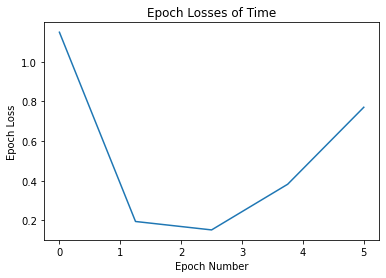

In [117]:
train_model(mlp_model, dataloader, num_epochs = 5, accumulation_steps = 4)

# Test model: 

In [118]:
dumb = next(iter(dataloader))
_, dumb_recon = mlp_model(dumb)

In [119]:
print(f"Input MLP test performance:")
sampled_mlp = sample_first_mlp_from_batch(dumb)
test_mlp(sampled_mlp, test_loader)

Input MLP test performance:


50.08

In [120]:
print(f"Output MLP test performance:")
sampled_mlp = sample_first_mlp_from_batch(dumb_recon)
test_mlp(sampled_mlp, test_loader)

Output MLP test performance:


10.28

In [121]:
k = 50 #dataset.__len__()
true = []
recon = []
for i in range(k):
    dumb = next(iter(dataloader))
    _, dumb_recon = mlp_model(dumb)
    true.append(test_mlp(sample_first_mlp_from_batch(dumb), test_loader))
    recon.append(test_mlp(sample_first_mlp_from_batch(dumb_recon), test_loader))

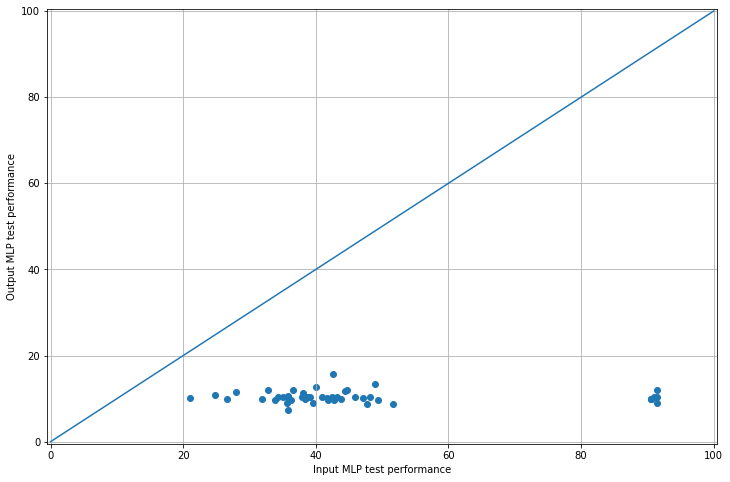

In [122]:
plt.figure(figsize=(12, 8))
plt.scatter(true, recon)
plt.plot( (0,100), (0,100) )
plt.xlim(-0.5, 100.5)
plt.ylim(-0.5, 100.5)

plt.xlabel(f"Input MLP test performance")
plt.ylabel(f"Output MLP test performance")
plt.grid()
plt.show()